In [1]:
print("tata");

tata


In [2]:
from unstructured.partition.pdf import partition_pdf

d:\tata\tata\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
raw_pdf_element=partition_pdf(
    filename=r"D:\tata\data\dashboard.pdf",
    strategy="hi_res",
    extract_images_in_pdf=True,
    extract_image_block_types=["Image","Table"],
    extract_image_block_to_payload=False,
    extract_image_block_output_dir="extracted_data"
)


In [7]:
img=[]
for element in raw_pdf_element:
  if "unstructured.documents.elements.Image" in str(type(element)):
    img.append(str(element))

In [8]:
tab=[]
for element in raw_pdf_element:
  if "unstructured.documents.elements.Table" in str(type(element)):
    tab.append(str(element))

In [9]:
ListItem =[]
for element in raw_pdf_element:
  if "unstructured.documents.elements.ListItem" in str(type(element)):
    ListItem.append(str(element))

In [10]:
NarrativeText =[]
for element in raw_pdf_element:
  if "unstructured.documents.elements.NarrativeText" in str(type(element)):
    NarrativeText.append(str(element))

In [11]:
len(img)

85

In [12]:
len(tab)

16

In [13]:
len(NarrativeText)

141

In [19]:
import os
from dotenv import load_dotenv

load_dotenv()
AZURE_OPENAI_API_KEY=os.getenv('AZURE_OPENAI_API_KEY')
AZURE_OPENAI_ENDPOINT=os.getenv('AZURE_OPENAI_ENDPOINT')
OPENAI_API_VERSION = os.getenv("OPENAI_API_VERSION")

Python-dotenv could not parse statement starting at line 4
Python-dotenv could not parse statement starting at line 5


In [21]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import AzureChatOpenAI

In [22]:
prompt_text = """You are an assistant tasked with summarizing tables for retrieval. \
    These summaries will be embedded and used to retrieve the raw table elements. \
    Give a concise summary of the table that is well optimized for retrieval. Table:{element} """

In [23]:
prompt = ChatPromptTemplate.from_template(prompt_text)

In [24]:
import os

os.environ["OPENAI_API_VERSION"] = OPENAI_API_VERSION
os.environ["AZURE_OPENAI_ENDPOINT"] = AZURE_OPENAI_ENDPOINT
os.environ["AZURE_OPENAI_API_KEY"] = AZURE_OPENAI_API_KEY

In [25]:
llm = AzureChatOpenAI(
    azure_deployment="gpt-4o",
    temperature=0,
)

In [26]:
llm

AzureChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x000001AC0536A250>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x000001AC05397400>, root_client=<openai.lib.azure.AzureOpenAI object at 0x000001AC010E0CA0>, root_async_client=<openai.lib.azure.AsyncAzureOpenAI object at 0x000001AC0536A2B0>, temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'), azure_endpoint='https://firstcycle.openai.azure.com/', deployment_name='gpt-4o', openai_api_version='2023-12-01-preview', openai_api_type='azure')

In [27]:
summarize_chain = {"element": lambda x: x} | prompt | llm | StrOutputParser()

In [28]:
table_summaries = []

In [29]:
table_summaries = summarize_chain.batch(tab, {"max_concurrency": 16})

In [31]:
table_summaries[1]

'Summary: The table provides information on driver alerts and indicators, including door ajar notifications, current gear position, and gear recommendations. It highlights that door alerts briefly pop up and then display a telltale. The current gear is shown on the display, with a note that "F" indicates a system defect requiring service. For manual transmissions, the gear number appears when the clutch is released. Gear recommendations are shown with arrows for shifting, except when the gear matches vehicle dynamics. Service intervals should be tracked manually, as the display retains information even if the battery is disconnected.'

### **Summarizing Text with table**

In [32]:
prompt_text = """You are an assistant tasked with summarizing text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text elements. \
    Give a concise summary of the table or text that is well optimized for retrieval.text: {element} """

In [33]:
prompt = ChatPromptTemplate.from_template(prompt_text)

In [34]:
model = AzureChatOpenAI(
    azure_deployment="gpt-4o",
    temperature=0,
)
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [36]:
text_summaries = []

text_summaries = summarize_chain.batch(NarrativeText, {"max_concurrency": 16})

In [37]:
len(text_summaries)

141

In [38]:
text_summaries[1]

"Low fuel warning blinks if there's a system defect; visit a TATA MOTORS Authorized Dealer/Service Center."

### **Images**

In [39]:
import base64
import os
from langchain_core.messages import HumanMessage

In [40]:
def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

In [42]:
def image_summarize(img_base64, prompt):
    """Make image summary"""
    chat = AzureChatOpenAI(model="gpt-4o", max_tokens=2000)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content

In [43]:
def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))


    return img_base64_list, image_summaries

In [44]:
fpath=r"D:\tata\experiment\extracted_data"

In [45]:
# Image summaries
img_base64_list, image_summaries = generate_img_summaries(fpath)

In [46]:
image_sum= image_summaries[:85]

In [47]:
len(image_sum)==len(img)

True

In [48]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document

In [49]:
from langchain_openai import AzureOpenAIEmbeddings

In [251]:
def create_multi_vector_retriever(vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )


    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
      doc_ids = [str(uuid.uuid4()) for _ in doc_contents]

      summary_docs = [
              Document(page_content=s, metadata={id_key: doc_ids[i]})
              for i, s in enumerate(doc_summaries)
          ]

      retriever.vectorstore.add_documents(summary_docs)
      retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    if text_summaries:
          add_documents(retriever,text_summaries,texts)
     
    if table_summaries:
          add_documents(retriever, table_summaries, tables)
     
    if image_summaries:
          add_documents(retriever, image_summaries, images)

    return retriever

vectorstore = Chroma(
    collection_name="mm_rag", embedding_function=AzureOpenAIEmbeddings(model="embeddtest")
)

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    NarrativeText,
    table_summaries,
    tab,
    image_sum,
    img_base64_list,
)

In [252]:
retriever_multi_vector_img

MultiVectorRetriever(vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x000001AC7BF90220>, docstore=<langchain_core.stores.InMemoryStore object at 0x000001AC6DFB5A30>, search_kwargs={})

In [253]:
import io
import re

from IPython.display import HTML, display
from PIL import Image

In [254]:
def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


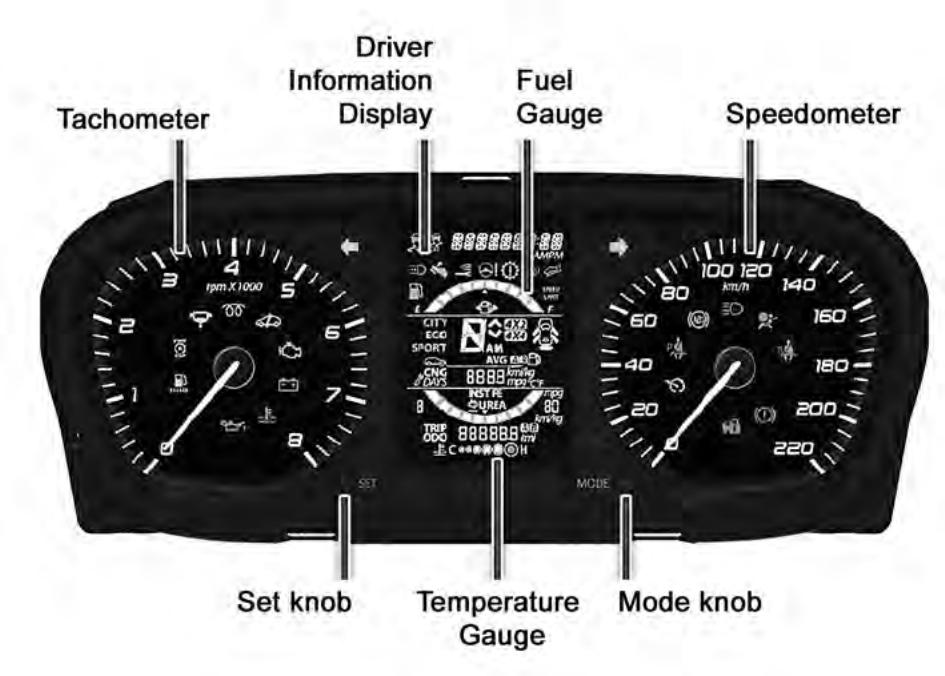

In [255]:
plt_img_base64(img_base64_list[5])

In [256]:
image_summaries[5]

'Dashboard display with labeled components: tachometer, driver information display, fuel gauge, speedometer, set knob, temperature gauge, and mode knob.'

In [257]:
query = "AFE value is an estimate of fuel economy It may vary significantly based upon drivingconditions, driving habits and condition of the vehicle."
docs = retriever_multi_vector_img.invoke(query, limit=10)

# We get 4 docs
len(docs)

0

In [258]:
print(docs[0])

IndexError: list index out of range

In [226]:
def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None

In [227]:
def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xFF\xD8\xFF": "jpg",
        b"\x89\x50\x4E\x47\x0D\x0A\x1A\x0A": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig,format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")

In [228]:
def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []

    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)

    return {"images": b64_images, "texts": texts}

In [229]:
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_openai import AzureOpenAI

In [230]:
def img_prompt_func(inputs):
    """
    Join the context into a single string and create messages for multimodal RAG.
    """
    # Join the context texts into a single string
    formatted_texts = "\n".join(inputs["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if "images" in inputs["context"] and inputs["context"]["images"]:
        for image in inputs["context"]["images"]:
            image_message = {
                "role": "system",
                "content": f"data:image/jpeg;base64,{image}",
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "role": "system",
        "content": (
            "You are a helpful Car assistant.\n"
            "You will be given a mix of information (text and/or images).\n"
            "Use this information to provide relevant details to the user's question.\n"
            "Use information that is given and give answer within the domain of vechile\n"
            "don't make answer with itself use only given information otherwise say I dont know \n"
            f"User-provided question: {inputs['question']}\n\n"
            "Text and/or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)

    return messages


In [231]:
def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = AzureChatOpenAI(temperature=0.5, model="gpt-4o", max_tokens=3000)


    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain

In [232]:
# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

In [233]:
chain_multimodal_rag

{
  context: MultiVectorRetriever(vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x000001AC6DFA5220>, docstore=<langchain_core.stores.InMemoryStore object at 0x000001AC6DF820D0>, search_kwargs={})
           | RunnableLambda(split_image_text_types),
  question: RunnablePassthrough()
}
| RunnableLambda(img_prompt_func)
| AzureChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x000001AC8E10A430>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x000001AC8E1759A0>, root_client=<openai.lib.azure.AzureOpenAI object at 0x000001AC6DFA5910>, root_async_client=<openai.lib.azure.AsyncAzureOpenAI object at 0x000001AC8E10AC40>, model_name='gpt-4o', temperature=0.5, model_kwargs={}, openai_api_key=SecretStr('**********'), max_tokens=3000, azure_endpoint='https://firstcycle.openai.azure.com/', openai_api_version='2023-12-01-preview', openai_api_type='azure')
| StrOutputParser()

In [234]:
def i_encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

def i_image_summarize(img_base64, prompt):
    """Make image summary"""
    chat = AzureChatOpenAI(model="gpt-4o", max_tokens=2000)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content

def generate_input_img_summary(image_path):
    """
    Generate a summary and base64 encoded string for a single image
    image_path: Path to the image file
    """
    # Prompt for summarization
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Encode the image to base64
    cbase64_image = i_encode_image(image_path)

    # Generate a summary for the image
    cimage_summary = i_image_summarize(cbase64_image, prompt)

    return cbase64_image, cimage_summary




In [235]:
cpath=r""

In [236]:
input_img_base64, input_image_summary = generate_input_img_summary(cpath)


FileNotFoundError: [Errno 2] No such file or directory: ''


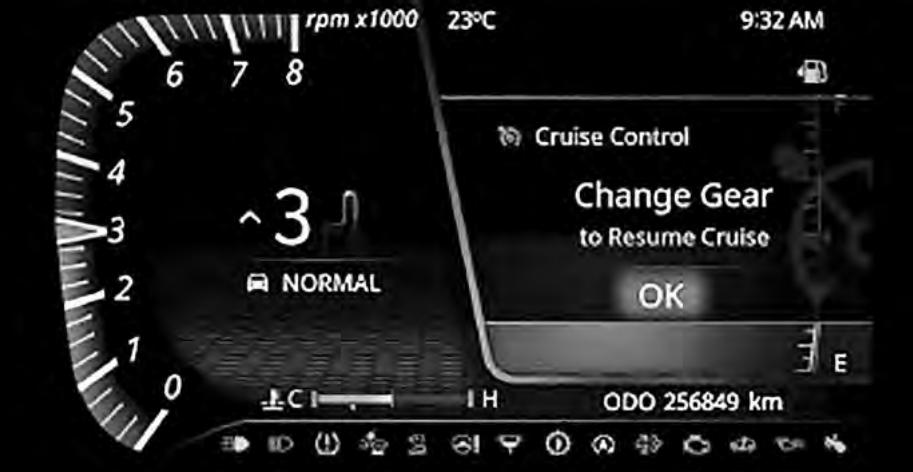

In [174]:
plt_img_base64(input_img_base64)

In [106]:
input_image_summary

'Car dashboard display showing RPM gauge, cruise control message to change gear, temperature at 23°C, time 9:32 AM, odometer reading 256849 km, and various indicator icons.'

In [271]:
query="""what is capital of india""" #given by user throught fast api as of I take it default
query1=""" Give me all 26 alert message and their warning or information Messages On Instrument Cluster """


In [272]:
from langchain_community.callbacks import get_openai_callback

In [273]:
with get_openai_callback() as cb:
  if cpath:
    # If cpath is not null, include the image summary in the query
    response = chain_multimodal_rag.invoke(
        input_image_summary + " this is the image description. Give answers based on this image: " + query1
    )
  else:
    # If cpath is null, invoke the model with only the query
     response = chain_multimodal_rag.invoke(query1)


In [274]:
print(response)

Here are the alert messages and their corresponding warnings or information messages on the instrument cluster:

1. **Rotate steering wheel (In ESCL jam condition)** - Press Start Button While Turning Wheel
2. **Key Fob battery Low** - Smart Key Battery Low Replace Battery
3. **Smart key out of range** - Smart Key Out of Range
4. **Drive Alert - Tea Break** - Take a Break
5. **Steering Failure, Please Stop Driving** - Steering Failure Stop the Vehicle Safely
6. **Steering Failure, Please Visit Garage** - Steering Failure Contact Service Center
7. **Pedal Press Alert Clutch** - Press Clutch Pedal to Start Engine
8. **Happy Birthday** - Happy Birthday
9. **Align Steering wheel** - Align Steering wheel


In [263]:
print(cb)

Tokens Used: 115
	Prompt Tokens: 111
	Completion Tokens: 4
Successful Requests: 1
Total Cost (USD): $0.0003175
